<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type LSTM pour réaliser des prédictions sur notre série temporelle.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

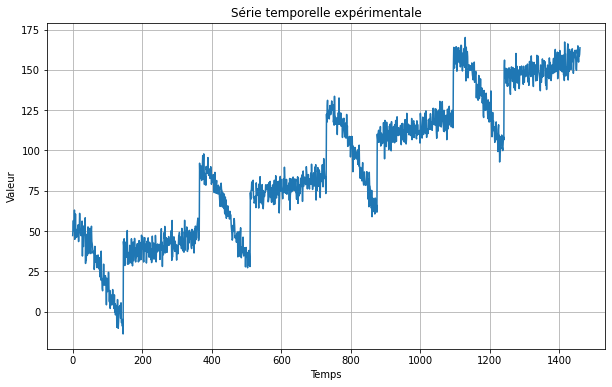

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Préparation des données X et Y

In [3]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [18]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [8]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)

# Création du modèle simple couche LSTM

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Le réseau que nous allons mettre en place est un réseau de neurones récurrent, composé de :
  - Une couche d'entrée récurrente de type LSTM à 40 neurones, de type séquence vers vecteur
  - Une couche de sortie dense avec 1 neurone

Pour adapter les données en entrée et en sortie du réseau au format attendu, nous allons utiliser une [couche de type lambda](https://keras.io/api/layers/core_layers/lambda/) avec Keras. Ce type de couche nous permet d'intégrer une fonction spécifique en tant que couche dans notre réseau de neurone.

- En entrée de la première couche récurrente, le format attendu est de type : [batch_size, #instants, #dims].   
Le **format d'entrée attendu est donc [None,None,1]** car notre série temporelle est de type univariée, qu'on souhaite pouvoir traiter une séquence infinie, et que le batch size est géré automatiquement par tensorflow.  
Il faut donc en entrée transformer le format [taille_fenetre, 1] vers le format [None, None, 1].  

- En sortie de la deuxième couche récurrente, le format est de type [batch_size, #instants, #neurones]. Il sera de type [None, None, 40].  
- La couche dense possède un seul neurone. En **sortie de la couche dense, le format est de type [None, None, 1]**.

Sous Keras, nous allons utiliser une couche récurrente de type LSTM avec la classe [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/). En sortie, la fonction d'activation par défaut est de type `tanh` qui sort une sortie comprise entre [-1,1]. Comme notre série possède des valeurs autour de 100, nous allons faire en sorte d'étendre la plage des valeurs en sortie de la couche dense en les multipliant par 100.

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/LSTM_1.png?raw=true" width="1200"> 

Pour insérer une dimension de type `None` au format de l'entrée, on utilise la méthode [expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims) de tensorflow. 

In [10]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.LSTM(40))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 40)                6720      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________


**2. Optimisation du taux d'apprentissage avec optimiseur Adam**

In [11]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [12]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-6*10**(periode/20)

# Définition de l'optimiseur à utiliser
#optimiseur=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
optimiseur=tf.keras.optimizers.Adam()

# Compile le modèle
#model.compile(loss="mse", optimizer=optimiseur)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage)])

Epoch 1/100
45/45 [==============================] - 3s 11ms/step - loss: 35.8838 - mae: 36.3803
Epoch 2/100
45/45 [==============================] - 1s 10ms/step - loss: 36.5328 - mae: 37.0300
Epoch 3/100
45/45 [==============================] - 1s 10ms/step - loss: 36.4417 - mae: 36.9378
Epoch 4/100
45/45 [==============================] - 1s 11ms/step - loss: 35.0248 - mae: 35.5201
Epoch 5/100
45/45 [==============================] - 1s 10ms/step - loss: 35.4362 - mae: 35.9301
Epoch 6/100
45/45 [==============================] - 1s 11ms/step - loss: 35.3178 - mae: 35.8138
Epoch 7/100
45/45 [==============================] - 1s 10ms/step - loss: 35.3400 - mae: 35.8368
Epoch 8/100
45/45 [==============================] - 1s 11ms/step - loss: 35.0091 - mae: 35.5054
Epoch 9/100
45/45 [==============================] - 1s 10ms/step - loss: 34.8411 - mae: 35.3371
Epoch 10/100
45/45 [==============================] - 1s 10ms/step - loss: 34.2116 - mae: 34.7080
Epoch 11/100
45/45 [=========

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

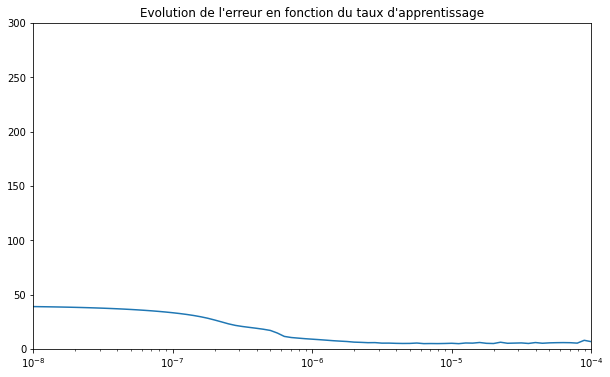

In [13]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/20))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ 1e-8, 1e-4, 0, 300])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [14]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(learning_rate=1e-5)

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
45/45 [==============================] - 2s 9ms/step - loss: 12.7775 - mae: 13.2700
Epoch 2/500
45/45 [==============================] - 1s 10ms/step - loss: 12.5595 - mae: 13.0537
Epoch 3/500
45/45 [==============================] - 1s 10ms/step - loss: 12.4713 - mae: 12.9658
Epoch 4/500
45/45 [==============================] - 1s 9ms/step - loss: 12.7355 - mae: 13.2279
Epoch 5/500
45/45 [==============================] - 1s 9ms/step - loss: 12.6820 - mae: 13.1736
Epoch 6/500
45/45 [==============================] - 1s 10ms/step - loss: 11.7986 - mae: 12.2875
Epoch 7/500
45/45 [==============================] - 1s 10ms/step - loss: 12.1463 - mae: 12.6372
Epoch 8/500
45/45 [==============================] - 1s 10ms/step - loss: 11.7054 - mae: 12.1951
Epoch 9/500
45/45 [==============================] - 1s 10ms/step - loss: 12.0550 - mae: 12.5474
Epoch 10/500
45/45 [==============================] - 1s 10ms/step - loss: 11.7477 - mae: 12.2397
Epoch 11/500
45/45 [============

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

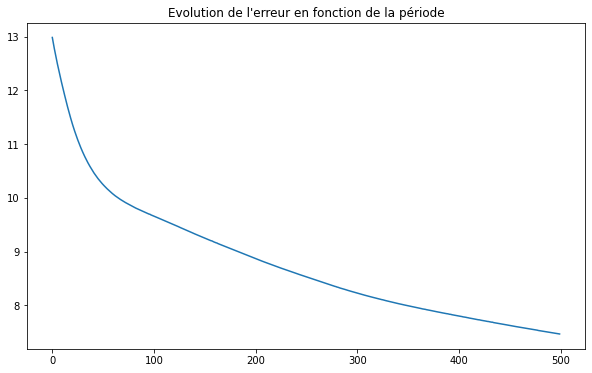

In [15]:
erreur = historique.history["loss"]
periodes = np.arange(0,len(erreur))

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(periodes,erreur)

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

Puisque le format d'entrée permet de prendre des séquences infinies, nous pouvons entrer des séquences de n'importe quelle taille :

In [16]:
X = np.reshape(serie[0:20],(1,20))
model.predict(X)

array([[52.02589]], dtype=float32)

In [19]:
taille_fenetre = 20
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

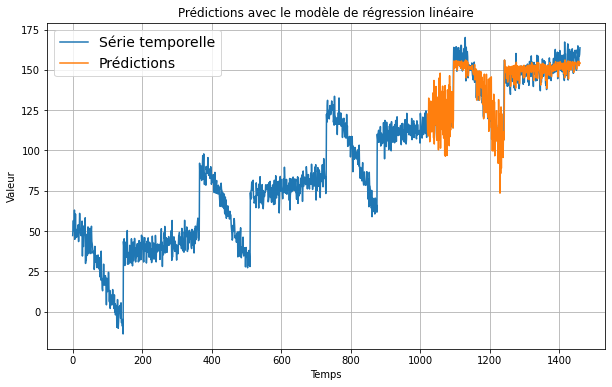

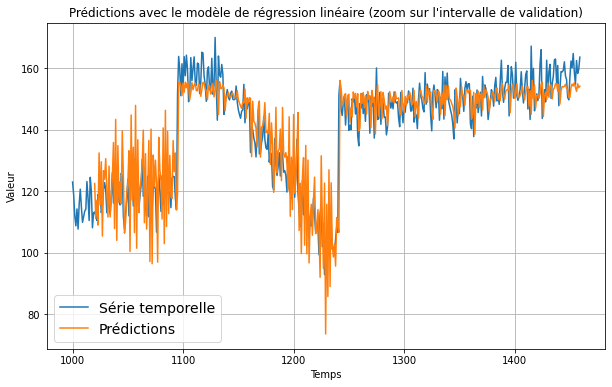

In [20]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [21]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

7.2195272
95.10657
